In [1]:
#bert-base-multilingual-uncased
#https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
#!pip install torch
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install transformers

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df =  pd.read_csv("/content/drive/MyDrive/telegram_data.csv")
df = df.dropna()
df.dropna(subset=['text'])
# Report the number of reviews.
print('Number of training texts: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.tail(10)

Number of training texts: 18,107



,date,post_url,text,summarized_text,regular_text_sentiment_label,regular_text_sentiment_score,summarized_text_sentiment_label,summarized_text_sentiment_score
18097,2023-12-18 09:05:00,https://t.me/NataliaForecast/2386/?embed=1&mod...,КуйбышевАзот-п \n \nПредыдущий реализованны...,«КуйбышевАзот-п» выпустил новый прогноз по ито...,positive,0.565658,negative,0.927684
18098,2023-12-18 10:01:00,https://t.me/NataliaForecast/2387/?embed=1&mod...,ДВМП \n \nПредыдущий реализованный прогноз ...,В сегменте нефтегазового рынка в ближайшее вре...,positive,0.938275,neutral,0.557556
18099,2023-12-18 18:28:00,https://t.me/NataliaForecast/2389/?embed=1&mod...,Сегодня на моем канале с аналитикой началась п...,На моем канале с аналитикой началась публикаци...,neutral,0.861358,neutral,0.869527
18100,2023-12-19 10:47:00,https://t.me/NataliaForecast/2390/?embed=1&mod...,Дублирую информацию по разблокировке \n \nС...,В СПБ Бирже согласовали стратегию разблокировк...,neutral,0.925975,neutral,0.816198
18101,2023-12-19 10:48:00,https://t.me/NataliaForecast/2391/?embed=1&mod...,United Medical \n \nПредыдущий реализованны...,В ближайшее время компания United Medical може...,positive,0.987271,positive,0.703147
18102,2023-12-20 08:02:00,https://t.me/NataliaForecast/2393/?embed=1&mod...,Сургутнефтегаз \n \nПредыдущий реализованны...,«Сургутнефтегаз» — один из крупнейших нефтегаз...,positive,0.959058,neutral,0.760683
18103,2023-12-22 09:52:00,https://t.me/NataliaForecast/2396/?embed=1&mod...,"Все, что нужно на сегодняшний день знать о раз...",В связи с введением санкций США в отношении СП...,neutral,0.848178,negative,0.914570
18104,2023-12-25 16:31:00,https://t.me/NataliaForecast/2397/?embed=1&mod...,Русагро \n \nПредыдущий реализованный прогн...,Российский агрохолдинг Русагро в ближайшее вре...,positive,0.459077,positive,0.655634
18105,2023-12-25 16:44:00,https://t.me/NataliaForecast/2398/?embed=1&mod...,Globaltrans \n \nПредыдущий реализованный п...,Российский автоконцерн Globaltrans в ближайшее...,negative,0.642319,negative,0.946584
18106,2023-12-26 08:01:00,https://t.me/NataliaForecast/2400/?embed=1&mod...,Fix Price — прогноз без существенных изменени...,В преддверии выборов в Госдуму прогнозируемых ...,positive,0.682236,positive,0.499481


In [6]:
import re
# Удаление эмодзи
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
#Удаление URL

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
#Удаление HTML-тегов
from bs4 import BeautifulSoup
#Function for removing html
def html(text):
    return BeautifulSoup(text, "lxml").text

In [7]:
df = df[['text', 'regular_text_sentiment_label']].copy()

In [8]:
df['sentiment'] = df['regular_text_sentiment_label']

In [9]:
df = df[['text', 'sentiment']].copy()

In [10]:
df['text'] = df['text'].str.replace('\n','')
df['text'].head()

,text
0,​​Спрос на морские перевозки падает — как это ...
1,Новое бюджетное правило в действии С 13 январ...
2,Ожидаемое замедление инфляции в США В декабр...
3,Главными событиями прошлой недели стали возвра...
4,​​Сбер: рост прибыли ускоряется рекомендация ...


In [11]:
df = df.drop(df[df.sentiment == "neutral"].index)
df = df.reset_index(drop=True)

In [12]:
df = df.sample(frac=1)
df = df.head(1500)
df.head(10)

,text,sentiment
2697,#GAZP Газпром в 2022г заключил с трубными за...,positive
4725,#Нефтянка Нефть Brent выше $90,positive
4151,#YNDX #Прогноз Прогноз целевой цены акций Ян...,positive
4475,#IPO Калужский ликероводочный завод Кристалл...,positive
6670,Ход торгов. ЛУКОЙЛ не дает индексу МосБиржи вы...,negative
10570,Очень продуктивная неделя получилась Рассмо...,positive
3079,#Банки #Авто Российские банки в I полугодии ...,positive
6345,Мечел отчитался за 2022. Добыча угля падает ...,negative
10136,Всё больше инвесторов начинают воспринимать би...,negative
1287,#RASP #Прогноз Прогноз аналитиков по акциям ...,positive


In [13]:
# Get the lists of sentences and their labels.
def categorise(row):
    if row['sentiment'] == 'negative':
        return 0
    elif row['sentiment'] == 'positive':
        return 1
df=df.dropna()
df = df[df['sentiment'] != 'neautral']
df['text_ready'] = df['text'].apply(emoji)
df['text_ready'] = df['text_ready'].apply(remove_urls)
df['text_ready'] = df['text_ready'].apply(html)
df[['text_ready']].head()
df['labels'] = df.apply(lambda row: categorise(row), axis=1)

In [14]:
df.sample(10)

,text,sentiment,text_ready,labels
4335,#Нефтянка Правительство РФ ожидает снижения ...,negative,#Нефтянка Правительство РФ ожидает снижения ...,0
559,#IRAO Интер РАО продемонстрировала рост фина...,positive,#IRAO Интер РАО продемонстрировала рост фина...,1
4399,#YNDX #VTBR ВТБ обсуждает обмен доли в Forten...,positive,#YNDX #VTBR ВТБ обсуждает обмен доли в Forten...,1
6056,"Комментарий Михаила Зельцера, эксперта БКС Мир...",positive,"Комментарий Михаила Зельцера, эксперта БКС Мир...",1
9933,Транснефть (TRNFP): отчетность за 1п2023 - на...,positive,Транснефть (TRNFP): отчетность за 1п2023 - нап...,1
9691,Прибыль Сбера (SBER) по итогам 2023 может прев...,positive,Прибыль Сбера (SBER) по итогам 2023 может прев...,1
4324,"#Политика Путин считает, что острую фазу кон...",positive,"#Политика Путин считает, что острую фазу кон...",1
9646,Оживление в секторе первичной недвижимости: п...,positive,Оживление в секторе первичной недвижимости: пр...,1
8533,ПАО «Полюс» Тикер PLZL Идея Long Горизонт 3...,positive,ПАО «Полюс» Тикер PLZL Идея Long Горизонт 3...,1
3765,#SBER #Недвижимость Число выдач льготной ипо...,positive,#SBER #Недвижимость Число выдач льготной ипо...,1


In [15]:
df.head(10)

,text,sentiment,text_ready,labels
2697,#GAZP Газпром в 2022г заключил с трубными за...,positive,#GAZP Газпром в 2022г заключил с трубными за...,1
4725,#Нефтянка Нефть Brent выше $90,positive,#Нефтянка Нефть Brent выше $90,1
4151,#YNDX #Прогноз Прогноз целевой цены акций Ян...,positive,#YNDX #Прогноз Прогноз целевой цены акций Ян...,1
4475,#IPO Калужский ликероводочный завод Кристалл...,positive,#IPO Калужский ликероводочный завод Кристалл...,1
6670,Ход торгов. ЛУКОЙЛ не дает индексу МосБиржи вы...,negative,Ход торгов. ЛУКОЙЛ не дает индексу МосБиржи вы...,0
10570,Очень продуктивная неделя получилась Рассмо...,positive,Очень продуктивная неделя получилась Рассмо...,1
3079,#Банки #Авто Российские банки в I полугодии ...,positive,#Банки #Авто Российские банки в I полугодии ...,1
6345,Мечел отчитался за 2022. Добыча угля падает ...,negative,Мечел отчитался за 2022. Добыча угля падает ...,0
10136,Всё больше инвесторов начинают воспринимать би...,negative,Всё больше инвесторов начинают воспринимать би...,0
1287,#RASP #Прогноз Прогноз аналитиков по акциям ...,positive,#RASP #Прогноз Прогноз аналитиков по акциям ...,1


In [16]:
df.loc[df.labels == 0].sample(5)[['text_ready', 'labels']]

,text_ready,labels
7750,ЕС запретил импорт алмазов из РФ с 2024. Оцени...,0
4180,#MOEX Мосбиржа объявила 50 дискретных аукцион...,0
3234,ПРАВИТЕЛЬСТВО ВНЕСЛО В ГОСДУМУ ПОПРАВКИ ПО НАЛ...,0
2961,#CHMF #Теханализ Акции Северстали не пробили...,0
1439,#Макро #Статистика Годовая инфляция в РФ на ...,0


In [17]:
# Get the lists of sentences and their labels.
sentences = df.text_ready.values
labels = df.labels.values

In [18]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [19]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (655 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1328


In [20]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  #GAZP   Газпром в 2022г заключил с трубными заводами договоры на 256 млрд рублей
Token IDs: tensor([  101,   108, 26534, 10373, 35615, 33039, 10392,   309, 73786, 11090,
        10242, 39601, 21134, 10571,   323,   324, 14148, 12063, 14071, 39033,
        10550, 35646, 10328, 10124, 21171, 36333, 52677,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [21]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,350 training samples
  150 validation samples


In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [23]:
from transformers import BertForSequenceClassification, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [24]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [25]:
!pip install adamp

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5981 sha256=05c8a50ea8d1dd4820d7c1aa2629bbd74a1cb4eb5d37887557016261cc504dc8
  Stored in directory: /root/.cache/pip/wheels/33/f9/d6/b2ed816e1f321f6dcf72a99c954223b1259477095f40434979
Successfully built adamp


In [26]:
from adamp import AdamP
optimizer = AdamP(model.parameters(),
                  lr=2e-5,
                  weight_decay=0.01)

In [27]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [28]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [30]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 34

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of     43.    Elapsed: 0:00:18.

  Average training loss: 0.54
  Training epcoh took: 0:00:20

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.49
  Validation took: 0:00:00

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     43.    Elapsed: 0:00:18.

  Average training loss: 0.38
  Training epcoh took: 0:00:19

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.39
  Validation took: 0:00:01

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     43.    Elapsed: 0:00:19.

  Average training loss: 0.23
  Training epcoh took: 0:00:20

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.38
  Validation took: 0:00:01

Training complete!
Total training took 0:01:00 (h:mm:ss)


In [31]:
#summary of the training process
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.54,0.49,0.77,0:00:20,0:00:00
2,0.38,0.39,0.82,0:00:19,0:00:01
3,0.23,0.38,0.85,0:00:20,0:00:01


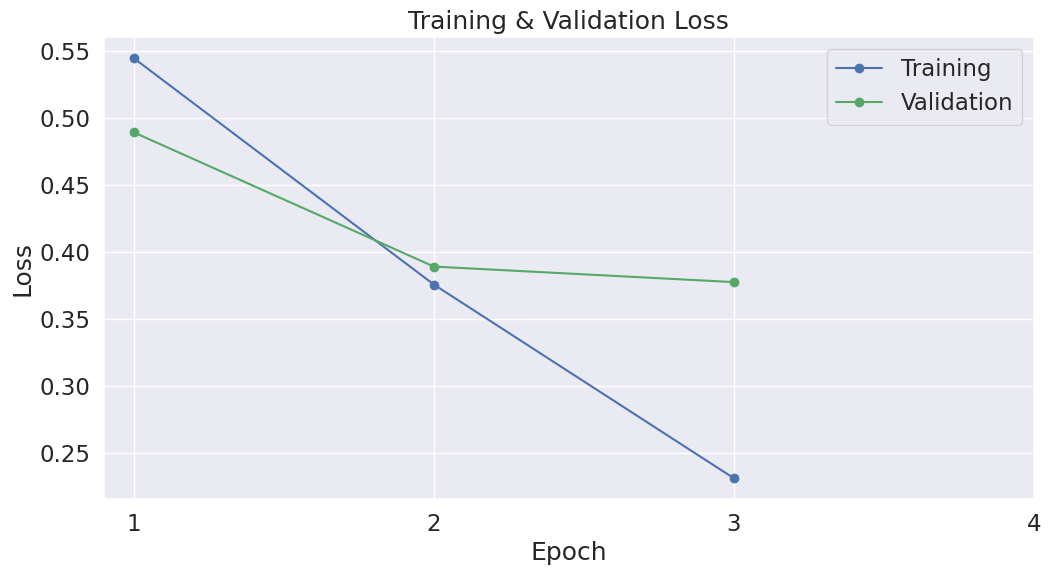

In [32]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()